In [1]:
# Data management
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modelling
# ------------------------------------------------------------------------------
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

from sklearn.metrics import accuracy_score
from sklearn import metrics 


# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
#warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('CSV_DEF_CLASIF.csv')
data.head()

,created_at,aid,extension,format,duration,FILE_STORED,FACIAL_ANALYSED,VOICE_ANALYSED,VOICE_TRANSCRIBED,BIOMETRICS_EXTRACTED,...,language,surprised_voice,no_speech_prob,entropy,tense_past,tense_present,tense_future,sentiment_polarity,sentiment_subjectivity,variable
0,1744824974,63612104-cc5c-4d54-b136-1f5880dece96,.mp4,video,NaN,True,True,False,True,False,...,en,NaN,0.006900,4.4125,0.3158,0.6842,0.0000,0.0932,0.5386,TDAH
1,1744825004,1afe2c00-8488-40f2-b3e1-5bd90fd57ad8,.mp4,video,213.0,True,True,True,True,True,...,en,0.043251,0.372388,4.3565,0.0769,0.9231,0.0000,0.2364,0.5069,TDAH
2,1744825017,6c987224-499c-469a-b908-dffef38c48b4,.mp4,video,115.0,True,True,True,True,True,...,es,0.190980,0.086458,4.1783,0.0000,1.0000,0.0000,0.3056,0.5162,Autismo
3,1744825025,e34d8573-7371-486a-900c-32a6ee78fabe,.mp4,video,202.0,True,True,True,True,True,...,es,0.006369,0.102629,4.2469,0.0833,0.7500,0.1667,0.2268,0.5349,Autismo
4,1744825037,5b442dc9-a39a-47e2-ba05-b0fe880ee44b,.mp4,video,135.0,True,True,True,True,True,...,es,0.047226,0.055492,4.2440,0.0833,0.9167,0.0000,0.2170,0.5825,Autismo


In [3]:
# Copia del dataframe original
df = data.copy()

# Columnas a eliminar (sin eliminar 'language')
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id'
]

# Eliminar columnas
df.drop(columns=cols_to_drop, inplace=True)

# Comprobación
print(f"Número de columnas tras la limpieza: {df.shape[1]}")
df.head()

Número de columnas tras la limpieza: 68


,angry_facial,disgust_facial,fear_facial,happy_facial,sad_facial,surprise_facial,neutral_facial,most_frequent_dominant_emotion,dominant_emotion_counts_surprise,average_face_confidence,...,language,surprised_voice,no_speech_prob,entropy,tense_past,tense_present,tense_future,sentiment_polarity,sentiment_subjectivity,variable
0,0.2098,0.0008,0.4117,0.1561,0.2053,0.0063,0.0099,sad,NaN,0.9500,...,en,NaN,0.006900,4.4125,0.3158,0.6842,0.0000,0.0932,0.5386,TDAH
1,0.0271,0.0000,0.1126,0.0005,0.6216,0.0001,0.2381,sad,NaN,0.9200,...,en,0.043251,0.372388,4.3565,0.0769,0.9231,0.0000,0.2364,0.5069,TDAH
2,0.1140,0.0000,0.1678,0.0062,0.4205,0.0020,0.2895,sad,NaN,0.9833,...,es,0.190980,0.086458,4.1783,0.0000,1.0000,0.0000,0.3056,0.5162,Autismo
3,0.0931,0.0771,0.1322,0.0408,0.3593,0.0007,0.2969,sad,NaN,0.9500,...,es,0.006369,0.102629,4.2469,0.0833,0.7500,0.1667,0.2268,0.5349,Autismo
4,0.0315,0.0001,0.0204,0.4411,0.2166,0.0009,0.2895,neutral,NaN,0.9167,...,es,0.047226,0.055492,4.2440,0.0833,0.9167,0.0000,0.2170,0.5825,Autismo


In [4]:
# Eliminar filas con clase 'Dispraxia'
df = df[df['variable'] != 'Dispraxia'].copy()

# Comprobación
print("Distribución de clases tras eliminar Dispraxia:")
print(df['variable'].value_counts())

Distribución de clases tras eliminar Dispraxia:
variable
Autismo     2093
Control     2033
TDAH        2030
Dislexia    2026
Name: count, dtype: int64


In [5]:
# Ver número de valores nulos por columna (ordenado)
df.isnull().sum().sort_values(ascending=False).head(20)

dominant_emotion_counts_surprise    7184
neutral_facial                       988
disgust_facial                       988
average_face_confidence              988
most_frequent_dominant_emotion       988
angry_facial                         988
surprise_facial                      988
sad_facial                           988
happy_facial                         988
fear_facial                          988
voice_kurtosis                       351
voice_median                         351
voice_mode                           351
voice_Q25                            351
voice_Q75                            351
voice_IQR                            351
voice_skewness                       351
voice_Q75_note                       351
voice_mean_note                      351
voice_median_note                    351
dtype: int64

In [6]:
print ("Tamaño del dataset:", df.shape)

Tamaño del dataset: (8182, 68)


In [7]:
# Eliminar columna con demasiados nulos
df.drop(columns=['dominant_emotion_counts_surprise'], inplace=True)

In [8]:
columnas_con_nulos = df.columns[df.isnull().any()].tolist()

# 3. Rellenar según el tipo de dato
for col in columnas_con_nulos:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"ℹ️ Columna categórica '{col}' rellenada con su moda")

# 4. Comprobar que ya no quedan nulos
total_nulos = df.isnull().sum().sum()
print(f"\n✅ Nulos restantes tras limpieza: {total_nulos}")

ℹ️ Columna categórica 'most_frequent_dominant_emotion' rellenada con su moda
ℹ️ Columna categórica 'voice_mean_note' rellenada con su moda
ℹ️ Columna categórica 'voice_median_note' rellenada con su moda
ℹ️ Columna categórica 'voice_mode_note' rellenada con su moda
ℹ️ Columna categórica 'voice_Q25_note' rellenada con su moda
ℹ️ Columna categórica 'voice_Q75_note' rellenada con su moda
ℹ️ Columna categórica 'language' rellenada con su moda

✅ Nulos restantes tras limpieza: 0


In [9]:
print ("Tamaño del dataset después (para comprobar que no se eliminan filas):", df.shape)

Tamaño del dataset después (para comprobar que no se eliminan filas): (8182, 67)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 1. Separar X e y
X = df.drop(columns=['variable'])  # variable objetivo
y = df['variable']

# 2. Identificar columnas categóricas para codificar
columnas_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Columnas categóricas a codificar:", columnas_categoricas)

# 3. Aplicar OneHotEncoding
X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

# 4. Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Comprobación final
print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Distribución de clases en y_train:\n", y_train.value_counts())

Columnas categóricas a codificar: ['most_frequent_dominant_emotion', 'voice_mean_note', 'voice_median_note', 'voice_mode_note', 'voice_Q25_note', 'voice_Q75_note', 'language']
Tamaño X_train: (6545, 179)
Tamaño X_test: (1637, 179)
Distribución de clases en y_train:
 variable
Autismo     1674
Control     1626
TDAH        1624
Dislexia    1621
Name: count, dtype: int64


📋 Classification Report:
              precision    recall  f1-score   support

     Autismo       0.74      0.72      0.73       419
     Control       0.66      0.76      0.71       407
    Dislexia       0.76      0.68      0.72       405
        TDAH       0.68      0.67      0.67       406

    accuracy                           0.71      1637
   macro avg       0.71      0.71      0.71      1637
weighted avg       0.71      0.71      0.71      1637



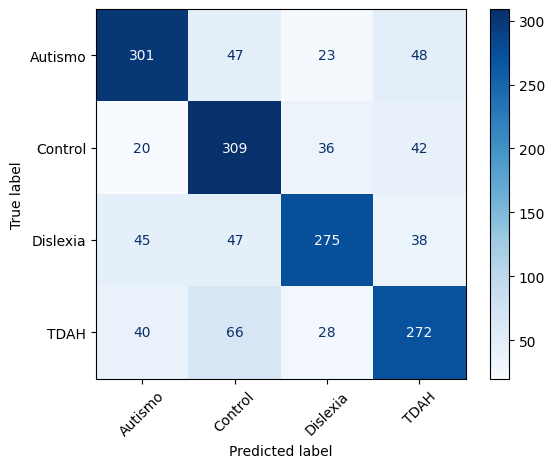

In [11]:
#SVM multiclase One-vs-Rest
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Crear pipeline con escalado + SVM
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', decision_function_shape='ovr', random_state=42))
])

# Entrenar
svm_model.fit(X_train, y_train)

# Predecir
y_pred = svm_model.predict(X_test)

# Evaluar
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45, cmap='Blues')


In [12]:
# Accuracy en test (ya lo tienes implícito, pero lo imprimimos)
test_acc = svm_model.score(X_test, y_test)
print(f"\n🎯 Accuracy en test: {test_acc:.3f}")

# Accuracy en entrenamiento
train_acc = svm_model.score(X_train, y_train)
print(f"🎯 Accuracy en train: {train_acc:.3f}")


🎯 Accuracy en test: 0.707
🎯 Accuracy en train: 0.833


Esto puede indicar overfitting. Lo que se busca ahora es encontrar la mejor combinación de hiperparámetros para el modelo SVC multiclase. Para ello:
- Ajustamos C: controla la penalización al error → baja = más generalización, alta = más rigidez
- Ajustamos gamma: controla cuánto influye un punto → alta = sobreajuste, baja = más suavidad

Esto ayudará a:
- Mejorar el accuracy en test
- Reducir el gap con el train
En definitiva, hacer que el modelo generalice mejor.
---

In [13]:
from sklearn.model_selection import GridSearchCV

# Definir rangos de búsqueda
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.01, 0.001],
    'svc__kernel': ['rbf']  # Si quieres, puedes añadir 'linear'
}

# Reutilizamos el pipeline pero lo renombramos
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(decision_function_shape='ovr', random_state=42))
])

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    svm_pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Resultados
print(f"🏆 Mejor combinación: {grid_search.best_params_}")
print(f"🔍 Mejor accuracy en validación: {grid_search.best_score_:.3f}")

# Evaluación en test final
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"🎯 Accuracy en test con mejores hiperparámetros: {test_accuracy:.3f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
🏆 Mejor combinación: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
🔍 Mejor accuracy en validación: 0.746
🎯 Accuracy en test con mejores hiperparámetros: 0.866


🔎 Resultados del GridSearchCV
🏆 Mejor combinación:

C = 10

gamma = 0.01

kernel = 'rbf'

📊 Accuracy en validación cruzada (CV): 0.746

🎯 Accuracy en test final: 0.866

✅ ¿Qué significa esto?
Has logrado un gran salto de rendimiento respecto al modelo inicial:

Pasaste de 0.707 a 0.866 de accuracy en test

La validación cruzada (0.746) es algo más baja que el test, pero está alineada, lo cual indica que el modelo no está sobreajustando, sino que generaliza bien.

---



📋 Classification Report del mejor modelo:
              precision    recall  f1-score   support

     Autismo       0.90      0.78      0.84       419
     Control       0.83      0.89      0.86       407
    Dislexia       0.91      0.92      0.92       405
        TDAH       0.83      0.88      0.85       406

    accuracy                           0.87      1637
   macro avg       0.87      0.87      0.87      1637
weighted avg       0.87      0.87      0.87      1637



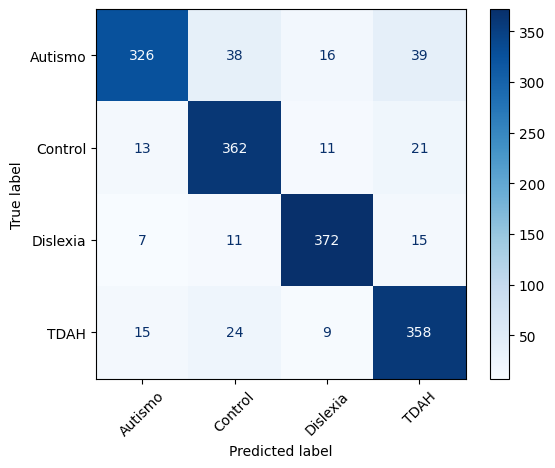

In [14]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Evaluación completa del mejor modelo
y_pred_best = best_model.predict(X_test)

print("\n📋 Classification Report del mejor modelo:")
print(classification_report(y_test, y_pred_best))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, xticks_rotation=45, cmap='Blues')

🧠 Interpretación:
El modelo está equilibrado entre clases: precisión, recall y f1 todos alrededor de 0.85–0.92

Mejora muy notable respecto al modelo inicial (que estaba en torno a 0.71 de accuracy)

Prácticamente todas las clases tienen recall y precisión muy altos

Dislexia es la mejor clasificada

Autismo tiene más confusión con TDAH

✅ Conclusión:
Tu SVM multiclase ahora es:

Preciso, generaliza bien

Balanceado, sin clase dominante

Ajustado correctamente, gracias a GridSearchCV

---


## EXPLICACIÓN EXTENSA CHAT

Claro, te explico el proceso paso a paso de cómo has mejorado tu modelo SVM multiclase usando `GridSearchCV`. Esto es muy útil tanto para tu comprensión como si tienes que explicarlo en un informe o presentación.

---

## 🔁 ¿Qué problema tenías?

El modelo original:

* Usaba valores por defecto (`C=1`, `gamma='scale'`)
* Daba un **accuracy en test de \~0.71** y en train de \~0.83 → posible **sobreajuste**
* El rendimiento por clase era moderado (F1 entre 0.67 y 0.73)

---

## 🎯 Objetivo con `GridSearchCV`

> Encontrar la **mejor combinación de hiperparámetros** para mejorar rendimiento general y evitar sobreajuste.

---

## ⚙️ Hiperparámetros explorados

Con `SVC`, puedes controlar el comportamiento del modelo con:

* **`C`**: penalización por error (bias vs variance)

  * Valores bajos: más generalización (modelo suave)
  * Valores altos: intenta clasificar todo bien (riesgo de overfitting)

* **`gamma`**: afecta a la forma de la frontera de decisión

  * Alto: curva muy ajustada a los datos (puede sobreajustar)
  * Bajo: curvas más suaves, más generalización

* **`kernel`**: función que proyecta los datos (usaste `'rbf'` → radial basis function, no lineal)

---

## 📦 ¿Cómo se usó `GridSearchCV`?

1. **Se definió un grid (rejilla de combinaciones)**:

   ```python
   param_grid = {
       'svc__C': [0.1, 1, 10],
       'svc__gamma': ['scale', 0.01, 0.001],
       'svc__kernel': ['rbf']
   }
   ```

2. **Se aplicó búsqueda exhaustiva** (`GridSearchCV`) probando todas las combinaciones, con validación cruzada (`cv=3`):

   ```python
   grid_search = GridSearchCV(svm_pipeline, param_grid, cv=3, scoring='accuracy')
   ```

3. **Entrenó 27 modelos distintos** (`3 C` × `3 gamma` × `1 kernel`).

4. **Seleccionó automáticamente la combinación con mejor accuracy medio en validación cruzada**:

   ```python
   {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
   ```

---

## 📈 ¿Qué lograste?

* Accuracy en test **subió de \~0.707 a \~0.866**
* El modelo se volvió más **robusto y generalizable**
* F1-score en todas las clases mejoró notablemente:

  * Dislexia: de 0.72 → 0.92
  * Autismo: de 0.73 → 0.84
  * Control: de 0.71 → 0.86
  * TDAH: de 0.67 → 0.85

---

## ✅ Resumen del proceso

| Paso                    | Acción                                                     |
| ----------------------- | ---------------------------------------------------------- |
| 1. Modelo base          | SVC con parámetros por defecto                             |
| 2. Evaluación           | Accuracy test bajo, gap con train → posible sobreajuste    |
| 3. GridSearchCV         | Se definieron combinaciones de `C` y `gamma`               |
| 4. Validación cruzada   | Evaluación robusta (cv=3) sobre cada combinación           |
| 5. Mejor modelo elegido | `C=10`, `gamma=0.01`, `kernel='rbf'`                       |
| 6. Resultados           | Accuracy en test: 0.866, rendimiento equilibrado por clase |

---

¿Te gustaría que también te prepare una versión explicativa de esto en texto profesional para ponerlo en tu memoria del TFG o presentación?
